In [1]:
from functools import reduce
from itertools import product
import os
import json

In [2]:
HEIGHT2STRIDE = {
    # 16: [2] * 4 + [1],
    32: [2] * 5,
    64: [4] + [2] * 4,
    128: [4] * 2 + [2] * 3,
    256: [4] * 3 + [2] * 2,
    # 512: [4] * 4 + [2] * 1, 
}

for k, v in HEIGHT2STRIDE.items():
    assert reduce(lambda x, y: x*y, v) == k

In [3]:
vocab = open('vocab.txt').read().splitlines()
vocab_size = len(vocab)
vocab_size

61

In [4]:
MODEL_IMG_SIZE = 128
DATA_IMG_SIZE = 64

In [5]:
def load_train_val_labels(img_size):
    with open("size2labels.json", 'rb') as f:
        size2labels = json.load(f)
    labels = size2labels[str(img_size)]
    val_labels = {k:v for k, v in labels.items() if int(k) < 100}
    train_labels = {k:v for k, v in labels.items() if int(k) >= 100}
    return train_labels, val_labels

# Dataset

In [6]:
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
from PIL import Image

In [7]:
class SimpleDataset(Dataset):
    def __init__(self, images_path, labels, image_size):
        self.images_path = images_path
        self.labels = labels
        self.image_size = image_size
        self.keys = sorted(list(labels.keys()))

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        idx = self.keys[idx]
        image_path = os.path.join(self.images_path, f'{idx}.png')
        image = Image.open(image_path)
        image = image.convert('RGB')

        aspect_ratio = image.width / image.height
        if aspect_ratio > 1:
            image = image.resize((int(self.image_size * aspect_ratio), self.image_size))
        else:
            image = image.resize((int(self.image_size * (1+aspect_ratio)), self.image_size))
        
        image = tv.transforms.ToTensor()(image)
        
        label = self.labels[str(idx)]
        return image, label

In [8]:
def prepare_dataloders(data_size, model_size):
    train_labels, val_labels = load_train_val_labels(data_size)
    train_dataset = SimpleDataset(f'images_size/size={data_size}/', train_labels, model_size)
    val_dataset = SimpleDataset(f'images_size/size={data_size}/', val_labels, model_size)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    return train_loader, val_loader

# Model

In [9]:
import torch

from crnn import CRNN
from ctc import GreedyCTCDecoder
from metrics import compute_f1, compute_exact

In [10]:
decoder = GreedyCTCDecoder()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
def prepare_batch(batch):
    images, texts = batch
    images = images.to(device)

    y = [[
        vocab.index(t) for t in txt
    ] for txt in texts]
    y = torch.tensor(y, dtype=torch.long).to(device)

    return images, texts, y

In [13]:
def get_ctc_loss(logits, y):
    logits = logits.permute(1, 0, 2).log_softmax(2)
    input_lengths = torch.full(
        size=(logits.size(1),),
        fill_value=logits.size(0),
        dtype=torch.int32,
    )
    target_lengths = torch.full(
        size=(y.size(0),),
        fill_value=y.size(1),
        dtype=torch.int32,
    )
    criterion = torch.nn.CTCLoss(zero_infinity=True)
    loss = criterion(logits, y, input_lengths, target_lengths)
    return loss

In [14]:
def get_predictions(logits):
    yp = logits.argmax(-1)
    pt = []
    for row in yp:
        predictions = decoder(row, None)
        pt.append(''.join(vocab[p] for p in predictions))
    return pt

In [15]:
def prepare_model(img_size):
    model = CRNN(imgH=img_size, vocab_size=vocab_size)
    state_dict = torch.load(f'cnn_size={img_size}.pth')
    model.load_state_dict(state_dict)
    _ = model.to(device)
    return model

In [19]:
size2size = {}
sizes = sorted(list(HEIGHT2STRIDE.keys()))
for model_size, data_size in product(sizes, sizes):
    # if model_size == data_size:
    #     continue

    model = prepare_model(model_size)
    _, val_loader = prepare_dataloders(data_size, model_size)

    model.eval()
    with torch.no_grad():
        val_losses = []
        val_f1 = []
        val_em = []
        for batch in val_loader:
            images, texts, y = prepare_batch(batch)
            logits = model(images)
            pt = get_predictions(logits)
            loss = get_ctc_loss(logits, y)

            val_losses.append(loss.item())
            for t, p in zip(texts, pt):
                val_f1.append(compute_f1(t, p))
                val_em.append(compute_exact(t, p))
    key = f'{model_size}x{data_size}'
    size2size[key] = {}
    size2size[key]["loss"] = sum(val_losses) / len(val_losses)
    size2size[key]["f1"] = sum(val_f1) / len(val_f1)
    size2size[key]["em"] = sum(val_em) / len(val_em)
    print(f'{key}: loss={size2size[key]["loss"]:.4f}, f1={size2size[key]["f1"]:.4f}, em={size2size[key]["em"]:.4f}')

32x32: loss=0.7514, f1=0.7902, em=0.6900
32x64: loss=1.3441, f1=0.5123, em=0.3700
32x128: loss=3.0073, f1=0.1633, em=0.0600
32x256: loss=4.2309, f1=0.1077, em=0.0300
64x32: loss=3.7291, f1=0.2556, em=0.1700
64x64: loss=0.3344, f1=0.8463, em=0.7800
64x128: loss=0.5547, f1=0.7963, em=0.7100
64x256: loss=0.6999, f1=0.7753, em=0.6600
128x32: loss=9.7491, f1=0.0142, em=0.0000
128x64: loss=1.1583, f1=0.5725, em=0.4600
128x128: loss=0.3225, f1=0.8334, em=0.7200
128x256: loss=0.4512, f1=0.8200, em=0.7300
256x32: loss=9.7236, f1=0.0079, em=0.0000
256x64: loss=2.5019, f1=0.1245, em=0.0600
256x128: loss=0.7123, f1=0.6485, em=0.4900
256x256: loss=0.2333, f1=0.7689, em=0.6500


In [20]:
with open('size2size.json', 'w') as f:
    json.dump(size2size, f)

# Plotting

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
sns.set_style("whitegrid")

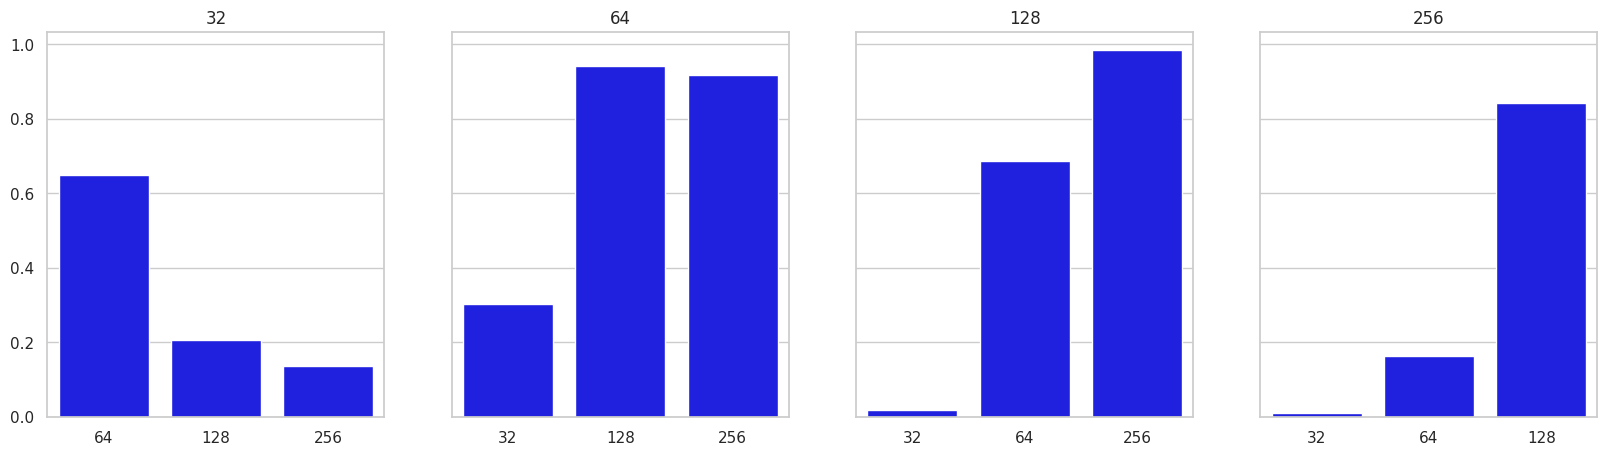

In [54]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.canvas.draw()
for size, ax in zip(sizes, axs.flatten()):
    reference_perfomance = size2size[f'{size}x{size}']
    reference_f1 = reference_perfomance["f1"]
    other_f1_performance = [size2size[f'{size}x{other_size}']["f1"]/reference_f1 for other_size in sizes if other_size != size]
    sns.barplot(x=list(range(len(other_f1_performance))), y=other_f1_performance, ax=ax, color='blue')
    ax.set_xticklabels([s for s in sizes if s != size])
    ax.set_title(f'{size}')

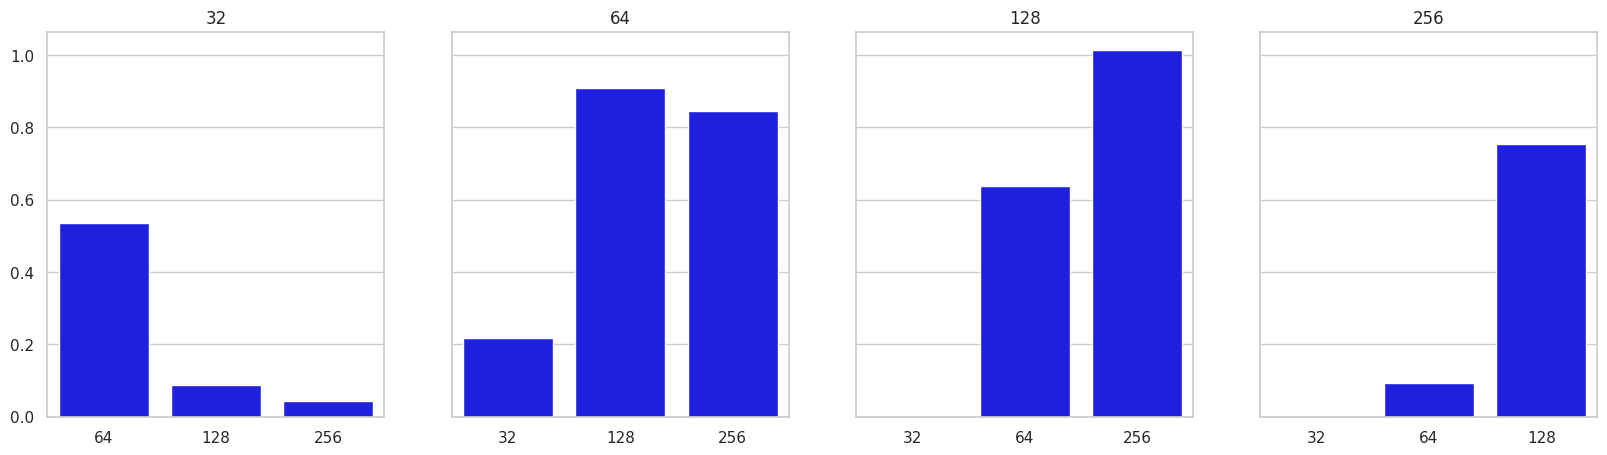

In [55]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.canvas.draw()
for size, ax in zip(sizes, axs.flatten()):
    reference_perfomance = size2size[f'{size}x{size}']
    reference_em = reference_perfomance["em"]
    other_em_performance = [size2size[f'{size}x{other_size}']["em"]/reference_em for other_size in sizes if other_size != size]
    sns.barplot(x=list(range(len(other_em_performance))), y=other_em_performance, ax=ax, color='blue')
    ax.set_xticklabels([s for s in sizes if s != size])
    ax.set_title(f'{size}')